In [ ]:
#import required statements
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
#from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "/kaggle/input/cremad/AudioWAV/"

# Output a sample dataset
dir_list = os.listdir(SAVEE)
dir_list[0:5]

['KL_d05.wav', 'KL_n13.wav', 'KL_f07.wav', 'JK_n20.wav', 'JE_n24.wav']

In [ ]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd

In [ ]:
#Manipulating and creating a SAVEE Dataframe
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()


male_neutral     120
male_surprise     60
male_happy        60
male_fear         60
male_sad          60
male_angry        60
male_disgust      60
Name: labels, dtype: int64

In [ ]:
#Manipulating and creating a RAVDESS Dataframe
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
female_disgust      96
female_sad          96
female_surprise     96
female_happy        96
male_angry          96
male_disgust        96
male_happy          96
male_sad            96
male_surprise       96
male_fear           96
female_angry        96
female_fear         96
Name: labels, dtype: int64

In [ ]:
#Manipulating and creating a TESS Dataframe
dir_list = os.listdir(TESS)
dir_list.sort()
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_surprise    400
female_neutral     400
female_angry       400
female_fear        400
female_disgust     400
female_sad         400
female_happy       400
Name: labels, dtype: int64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dir_list = os.listdir(CREMA)
dir_list.sort()

In [ ]:
#Manipulating and creating a CREMA Dataframe
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_sad          671
male_angry        671
male_happy        671
male_fear         671
male_disgust      671
female_angry      600
female_fear       600
female_sad        600
female_happy      600
female_disgust    600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [ ]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
#df.to_csv("Data_path.csv",index=False)

female_fear        1096
female_sad         1096
female_happy       1096
female_disgust     1096
female_angry       1096
female_neutral     1056
male_neutral        839
male_angry          827
male_fear           827
male_sad            827
male_happy          827
male_disgust        827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64


,labels,source,path
0,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


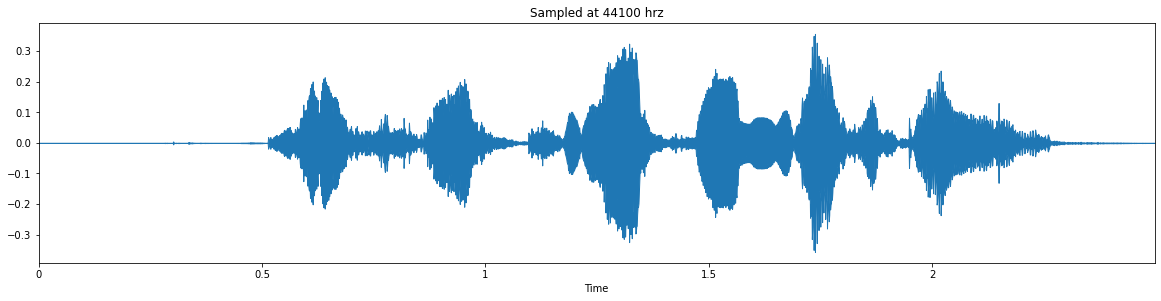

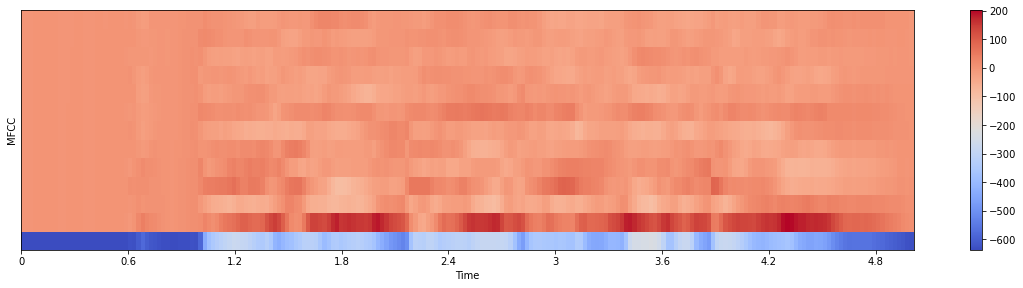

In [ ]:
#feature extraction -> using MFCC
# From the RAVDESS dataset => Gender - Female; Emotion - Angry 
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13) 

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

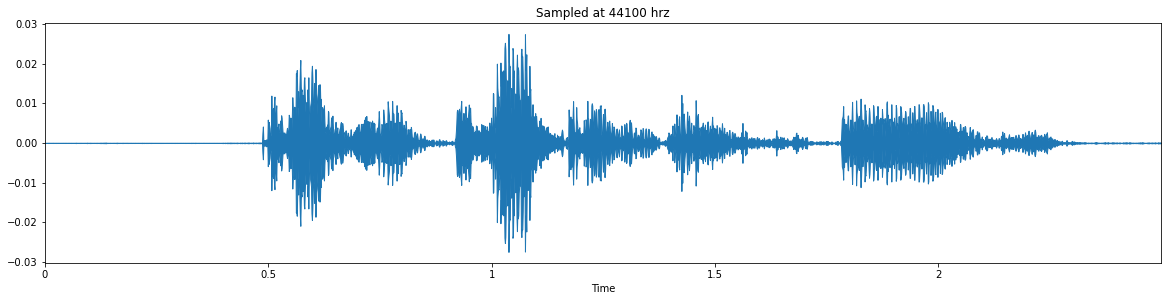

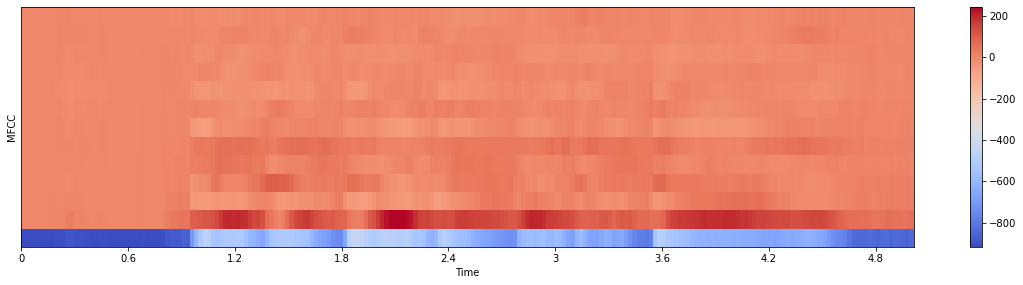

In [ ]:
# From the RAVDESS => Gender - Male; Emotion - Angry 
path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

In [ ]:
data_path = pd.read_csv("/kaggle/input/mydataset/Data_path.csv")
data_path.head()

,labels,source,path
0,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


In [ ]:
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(data_path.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   
#df.to_csv("features.csv")

In [ ]:

df = pd.read_csv("../input/feature/features.csv")
df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-25.376921,-24.842583,-25.312065,-24.858978,-26.600643,-26.726088,-25.850971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-11.113935,-7.215755,-6.219191,-5.926543,-5.850419,-4.808960,-2.513002,...,-4.088852,-5.023864,-5.254715,-5.234093,-5.310308,-5.621666,-6.072196,-6.611347,-2.509089,1.964607
2,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-27.450253,-26.854012,-26.683601,-27.648073,-28.751026,-30.146671,-28.018799,...,-5.983144,-6.797939,-7.641075,-8.502517,-8.663110,-11.605279,-16.408430,-19.296211,-22.340641,-24.666119
3,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-5.234546,-6.687391,-16.406271,-17.042978,-16.232885,-14.091496,-13.224945,...,-26.130611,-26.350634,-25.106792,-23.058765,-23.787733,-23.516254,-24.285072,-23.437519,-22.714952,-23.930023
4,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-28.316051,-28.186119,-27.667511,-19.379509,-11.144135,-8.123636,-8.312647,...,-27.069855,-27.943575,-28.134996,-28.179310,-28.849735,-28.935709,-28.182568,-29.281555,-29.144468,-27.194292


In [ ]:
#filling null values with NA
df=df.fillna(0)
print(df.shape)

(12162, 219)


In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-18.611181,-17.616535,-18.411484,-18.987421,-17.404621,-16.747271,-17.733749,-18.055027,-17.931210,-15.913168,...,-22.899403,-21.647814,-19.758656,-18.879402,-19.397377,-20.171659,-22.689241,-24.612816,-24.153774,-22.703135
3860,-17.367287,-21.216658,-27.259260,-27.316660,-28.886757,-31.021534,-28.050455,-27.100908,-26.216240,-25.999886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,-1.533946,-4.030605,-9.614023,-12.045175,-9.992991,-11.926253,-14.008464,-13.561556,-14.024567,-15.151946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,-4.531077,-3.933793,-4.567834,-5.871509,-5.282473,-6.490458,-8.156469,-9.188803,-8.681726,-8.212408,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,-20.621704,-21.587505,-20.563650,-20.703459,-21.205717,-18.608528,-18.446669,-16.211843,-14.257651,-15.160404,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7914,-17.514992,-18.551868,-17.043013,-16.977903,-19.369631,-19.562130,-22.008749,-20.178379,-17.989595,-19.336285,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9513,-18.740368,-18.824934,-16.149492,-16.963455,-18.229979,-18.183958,-19.274342,-18.395124,-16.951286,-16.672031,...,-17.882132,-19.390713,-17.779474,-19.165974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5835,-19.066851,-18.328382,-17.710285,-18.043194,-18.252481,-18.710625,-16.626354,-17.831005,-18.028345,-17.859104,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5389,-20.760588,-20.047142,-18.961346,-19.468687,-19.316296,-18.162565,-18.102333,-19.914131,-20.931385,-19.215494,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11222,-18.252928,-17.727367,-19.222475,-18.469973,-17.572327,-17.850544,-17.932026,-20.588900,-18.612183,-15.990725,...,-18.065437,-18.135094,-19.665306,-20.741903,-20.273037,-18.371035,-15.576725,-17.512487,-17.008547,-18.195280


In [ ]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# after normalisation 
X_train[150:160]


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,0.185986,0.302547,0.436216,0.387012,0.497589,0.542060,0.460953,0.431746,0.434787,0.580609,...,-0.877956,-0.811298,-0.690761,-0.629001,-0.675062,-0.717815,-0.860972,-0.984873,-0.969587,-0.878612
3860,0.273032,0.040719,-0.221177,-0.230337,-0.351758,-0.513618,-0.300603,-0.235339,-0.175869,-0.163161,...,0.540144,0.526610,0.526006,0.526618,0.511547,0.511441,0.512463,0.500913,0.495901,0.491369
9761,1.381017,1.290618,1.089871,0.901560,1.045836,0.898606,0.735945,0.763115,0.722730,0.636740,...,0.540144,0.526610,0.526006,0.526618,0.511547,0.511441,0.512463,0.500913,0.495901,0.491369
7620,1.171284,1.297659,1.464805,1.359141,1.394278,1.300620,1.167925,1.085582,1.116530,1.148445,...,0.540144,0.526610,0.526006,0.526618,0.511547,0.511441,0.512463,0.500913,0.495901,0.491369
11586,0.045294,0.013748,0.276309,0.259822,0.216418,0.404407,0.408327,0.567671,0.705550,0.636116,...,0.540144,0.526610,0.526006,0.526618,0.511547,0.511441,0.512463,0.500913,0.495901,0.491369
7914,0.262695,0.234522,0.537894,0.535954,0.352235,0.333882,0.145382,0.275160,0.430484,0.328197,...,0.540144,0.526610,0.526006,0.526618,0.511547,0.511441,0.512463,0.500913,0.495901,0.491369
9513,0.176946,0.214663,0.604283,0.537025,0.436536,0.435807,0.347230,0.406666,0.507013,0.524653,...,-0.567249,-0.671802,-0.568881,-0.646542,0.511547,0.511441,0.512463,0.500913,0.495901,0.491369
5835,0.154099,0.250776,0.488315,0.456996,0.434872,0.396856,0.542698,0.448266,0.427628,0.437121,...,0.540144,0.526610,0.526006,0.526618,0.511547,0.511441,0.512463,0.500913,0.495901,0.491369
5389,0.035575,0.125775,0.395361,0.351341,0.356180,0.437389,0.433745,0.294647,0.213656,0.337104,...,0.540144,0.526610,0.526006,0.526618,0.511547,0.511441,0.512463,0.500913,0.495901,0.491369
11222,0.211056,0.294486,0.375959,0.425364,0.485184,0.460465,0.446316,0.244887,0.384595,0.574891,...,-0.578601,-0.594200,-0.685013,-0.743006,-0.728629,-0.608085,-0.430434,-0.556252,-0.536063,-0.606593


In [ ]:
#converting to numpy array 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
#for labelling process
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


In [ ]:
#a file with labels is created
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

In [ ]:
#building a CNN model
import tensorflow as tf
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
571/571 [==============================] - 104s 182ms/step - loss: 2.4233 - accuracy: 0.1911 - val_loss: 2.4670 - val_accuracy: 0.1743
Epoch 2/100
571/571 [==============================] - 102s 178ms/step - loss: 2.1939 - accuracy: 0.2626 - val_loss: 2.2429 - val_accuracy: 0.2660
Epoch 3/100
571/571 [==============================] - 102s 178ms/step - loss: 2.0874 - accuracy: 0.2943 - val_loss: 2.1483 - val_accuracy: 0.3081
Epoch 4/100
571/571 [==============================] - 102s 179ms/step - loss: 2.0141 - accuracy: 0.3076 - val_loss: 2.0973 - val_accuracy: 0.3157
Epoch 5/100
571/571 [==============================] - 104s 182ms/step - loss: 1.9546 - accuracy: 0.3326 - val_loss: 2.0498 - val_accuracy: 0.3232
Epoch 6/100
571/571 [==============================] - 103s 181ms/step - loss: 1.9081 - accuracy: 0.3486 - val_loss: 2.0092 - val_accuracy: 0.3427
Epoch 7/100
571/571 [==============================] - 103s 181ms/step - loss: 1.8700 - accuracy: 0.3558 - val_loss: 1

571/571 [==============================] - 105s 184ms/step - loss: 1.2538 - accuracy: 0.5703 - val_loss: 1.6145 - val_accuracy: 0.4351
Epoch 57/100
571/571 [==============================] - 104s 181ms/step - loss: 1.2457 - accuracy: 0.5760 - val_loss: 1.6003 - val_accuracy: 0.4479
Epoch 58/100
571/571 [==============================] - 105s 184ms/step - loss: 1.2353 - accuracy: 0.5782 - val_loss: 1.6131 - val_accuracy: 0.4387
Epoch 59/100
571/571 [==============================] - 106s 185ms/step - loss: 1.2298 - accuracy: 0.5845 - val_loss: 1.5915 - val_accuracy: 0.4452
Epoch 60/100
571/571 [==============================] - 104s 182ms/step - loss: 1.2164 - accuracy: 0.5864 - val_loss: 1.5942 - val_accuracy: 0.4433
Epoch 61/100
571/571 [==============================] - 103s 180ms/step - loss: 1.2149 - accuracy: 0.5811 - val_loss: 1.6277 - val_accuracy: 0.4321
Epoch 62/100
571/571 [==============================] - 104s 182ms/step - loss: 1.2102 - accuracy: 0.5907 - val_loss: 1.5878 

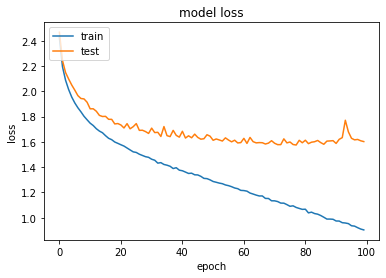

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#save the model and check for predictions
model_name = 'MyEmotionModel.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/MyEmotionModel.h5 


In [ ]:
#check for model validation
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/MyEmotionModel.h5")
#print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds                                     

191/191 [==============================] - 7s 38ms/step


array([ 4,  3, 11, ..., 10,  4,  0])

In [ ]:
#predicted labels
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# combine to a single dataframe
finaldf = actual.join(preds)
#sample to print
#finaldf[120:130]

In [ ]:
#print and check for sample values
finaldf[50:60]

,actualvalues,predictedvalues
50,female_angry,female_angry
51,female_angry,female_angry
52,male_disgust,female_happy
53,male_happy,male_happy
54,male_happy,male_angry
55,female_disgust,female_neutral
56,female_fear,female_fear
57,female_surprise,female_surprise
58,female_disgust,female_disgust
59,male_happy,female_happy


In [ ]:
#further exploring data
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_disgust,female_fear
172,male_angry,male_angry
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_happy
176,male_disgust,male_disgust
177,female_fear,female_fear
178,female_happy,female_happy
179,female_neutral,female_neutral


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)
#finaldf.groupby('predictedvalues').count()

In [ ]:
# Get the predictions file 
finaldf = pd.read_csv("./Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
#c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
#print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))

In [ ]:
data, sampling_rate = librosa.load('../input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_n08.wav')
ipd.Audio('../input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_sa08.wav')

In [ ]:
json_file = open('./model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./saved_models/MyEmotionModel.h5")

# the optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Lets transform the dataset so we can apply the predictions
X, sample_rate = librosa.load('../input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_n08.wav'
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)                                                                                                                               
newdf = pd.DataFrame(data=mfccs)
newdf

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-3.071378,-4.777808,-9.49904,-14.791615,-17.805727,-18.439564,-19.118105,-19.942043,-22.083479,-23.045044,...,-19.657095,-22.243639,-22.978039,-24.006531,-24.615187,-25.283833,-25.06918,-24.947102,-23.152611,-18.667309


In [ ]:
# Apply predictions
newdf= np.expand_dims(newdf, axis=2)
newpred = loaded_model.predict(newdf, 
                         batch_size=16, 
                         verbose=1)

newpred

1/1 [==============================] - 0s 2ms/step


array([[1.3665188e-26, 6.1897483e-18, 1.1776126e-19, 4.7859030e-15,
        2.6071992e-21, 9.7555345e-19, 1.9475728e-17, 5.4307558e-23,
        2.0457576e-03, 2.1861731e-12, 7.0607819e-16, 9.9794680e-01,
        7.5172197e-06, 1.3365985e-22]], dtype=float32)

In [ ]:
filename = './labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final)

['male_neutral']
